In [0]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import json
from pandas.io.json import json_normalize

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
path = '/gdrive/My Drive/NYU/Spring 2019/Urban Science Intensive I/Getting to Zero Capstone /Data'

os.listdir(path)

['SoP-fulcrum-data.xlsx',
 'Target-variables.pdf',
 'pedestrian_collisions',
 'road_network_data',
 'VZW',
 'Subway Entrances',
 'Variable analysis-Robin.ipynb',
 'Data inventory.gsheet',
 'Brownsville-CleanedData.xlsm',
 'SoP data analysis - Correlation.ipynb',
 'SoP_data',
 'SoP_Data_For_NYU.xlsx',
 'SoP data - json to pandas.ipynb',
 'Open data.gdoc',
 'Brownsville',
 'SoP interpretation.xlsx',
 'dataJoin',
 'Google Places',
 'planimetric',
 'NYC Open Data - Schools',
 'StreetScore & CitiBike',
 'NYC Open Data - Street trees',
 'NYC Open Data',
 'pluto',
 'NYC_samples',
 'Join_datasets_07_01.ipynb',
 'SoPNYU_MapVML.xlsx',
 'XGBoost models',
 'Culdesac',
 '.ipynb_checkpoints',
 'Control variables',
 'Community_Boards',
 'SoPProfileGeneratorForMultipleBlocksFinal20190619ForNYU.xlsx',
 'Variable-map.xlsx',
 'VML_variables.csv',
 'SoP_algorithm_results.xlsx',
 'SoP variables and where to find them.gsheet',
 'SoP data analysis - predicted dimensions exploration.ipynb',
 'SoP data analysi

## Read data

In [0]:
#df = pd.concat([get_sop_data(path + '/SoP_data/NewYork'), get_sop_data(path + '/SoP_data/Durham')])

df = pd.read_excel(path + '/SoP_Data_For_NYU.xlsx')

df.head()

,created_at,Source,Latitude,Longitude,country,State,City,Neighborhood,NeighCity,BlockName,Intersc1,intersection_1_location,Intersc2,intersection_2_location,Monument,Croswalk,WhitLine,ColrLine,ZebraStp,DiffRdSf,CmOther,CrssCnvt,MarkSfCn,Curbcuts,CurbCLoc,CurbCond,TraffSig,StopSign,YieldSgn,PedAuto,PedActSgn,PedCntDwn,PedSound,PedCrsSgn,TraffAsst,PdUnOvPs,TrfPdSfConv,PdPassConv,PdPassMaint,CrssTime,...,ZStrpMalllNT,ZRetRestINT,ZCommOthrINT,ZRestarntINT,ZCoffShopINT,ZCornerStINT,ZMovieThINT,ZBarsClubINT,ZVehLanesTotRecoded,ZCulSacPedPtINT,ZTrafCalmTot,ZMidCrsMarkINT,ZTrafCalmTotINT,FORM3,DENS2,PROX3,CONN5,PARKS2,PEDS3,SAFE,TRAFFIC5,AESTONE3,AESTTWO2,AESTTOT3,PAF2,SoPIndex6,CONN3,PEDS2,PAF,TRAFFIC2,TRAFFIC3,TRAFFIC4,CONN4,SoPIndex,SoPIndex2,SoPIndex3,SoPIndex4,SoPIndex5,UniqueID,BlocksInNeigh
0,NaN,BK,NaN,NaN,NaN,DC,Washington,Adams Morgan,Adams MorganWashington,Block 1,13th/Monroe,NaN,Holmead/Monroe,NaN,1,2,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,-0.157762,-0.60741,-0.307088,-0.401981,-0.200916,-0.218442,-0.067041,-0.153042,-0.526942,-0.212338,-0.245191,0.268268,0.864661,-6.12806,2.874262,-5.159501,-1.206788,-1.474060,-3.065233,-1.553903,8.175600,5.972664,-4.088193,10.060857,-0.458281,16.734588,-0.530432,-1.771195,-0.278211,4.415523,4.588448,6.525796,-0.874178,13.772263,13.935939,14.268549,13.147436,15.084784,20,23
1,NaN,BK,NaN,NaN,NaN,DC,Washington,Adams Morgan,Adams MorganWashington,Block 2,Spring/Perry,NaN,Spring/Perry,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.157762,-0.60741,-0.307088,-0.401981,-0.200916,-0.218442,-0.067041,-0.153042,0.250393,-0.212338,4.077907,0.268268,-0.236523,-6.12806,0.142780,-5.159501,-0.429453,-1.474060,-1.870462,-4.517316,2.294020,-2.751330,-3.397105,0.645776,-0.458281,-3.839532,-0.530432,-0.576424,-0.278211,4.704832,4.812709,0.644216,-0.176847,0.146367,-0.387288,-0.134682,-1.320843,-5.489336,21,23
2,NaN,BK,NaN,NaN,NaN,DC,Washington,Adams Morgan,Adams MorganWashington,Block 3,10th/Girard,NaN,11th/Girard,NaN,0,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,-0.157762,-0.60741,-0.307088,-0.401981,-0.200916,-0.218442,-0.067041,-0.153042,1.027727,-0.212338,-0.245191,0.268268,-1.337708,3.28164,0.142780,-5.159501,0.347882,-1.474060,-2.552961,-6.903792,-1.319474,-4.071767,6.972057,-11.043824,-0.458281,-32.398635,-5.769840,-1.258923,-0.278211,-2.747085,-2.704257,-2.969278,-4.718924,-26.234417,-27.465403,-32.532208,-33.783418,-34.048439,22,23
3,NaN,BK,NaN,NaN,NaN,DC,Washington,Adams Morgan,Adams MorganWashington,Block 4,13th/Columbia,NaN,14th/Columbia,NaN,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,-0.157762,-0.60741,-0.307088,-0.401981,-0.200916,-0.218442,-0.067041,-0.153042,0.250393,-0.212338,-0.245191,0.268268,-0.236523,-6.12806,0.142780,1.353831,-0.429453,6.621589,1.176331,-0.093453,8.152727,-2.709658,-5.535333,2.825675,-0.458281,26.278710,-0.530432,2.470369,-0.278211,5.558883,5.666760,6.502924,-0.176847,25.259953,24.726298,24.978904,23.792743,24.628906,23,23
4,NaN,BK,NaN,NaN,NaN,DC,Washington,Adams Morgan,Adams MorganWashington,Block 5,Hertford/Ogden,NaN,Hertford/Oak,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.157762,-0.60741,-0.307088,-0.401981,-0.200916,-0.218442,-0.067041,-0.153042,0.250393,-0.212338,4.077907,0.268268,-0.236523,-6.12806,0.142780,-5.159501,-0.429453,-1.474060,-1.870462,-2.662305,-4.360258,-2.646229,-3.397105,0.750876,-0.458281,-8.533698,-0.530432,-0.576424,-0.278211,-1.949446,-1.841569,-6.010061,-0.176847,-4.547799,-5.081454,-4.828848,-6.015009,-10.183502,24,23


In [0]:
df.shape

(3585, 860)

In [0]:
#Get columnas corresponding to SoP Dimensions + Index (there are more than one for each - different versions of the SoP algorithm)
sop_dims = ['FORM', 'DENS', 'PROX', 'CONN', 'PARKS', 'PEDS', 'SAFE', 'TRAFFIC', 'AESTTOT', 'PAF', 'SoPIndex']
col_dims_all = [col for col in df.columns if any(dim in col for dim in sop_dims)]
col_dims_all

['FORM3',
 'DENS2',
 'PROX3',
 'CONN5',
 'PARKS2',
 'PEDS3',
 'SAFE',
 'TRAFFIC5',
 'AESTTOT3',
 'PAF2',
 'SoPIndex6',
 'CONN3',
 'PEDS2',
 'PAF',
 'TRAFFIC2',
 'TRAFFIC3',
 'TRAFFIC4',
 'CONN4',
 'SoPIndex',
 'SoPIndex2',
 'SoPIndex3',
 'SoPIndex4',
 'SoPIndex5']

In [0]:
list(df.columns)

['created_at',
 'Source',
 'Latitude',
 'Longitude',
 'country',
 'State',
 'City',
 'Neighborhood',
 'NeighCity',
 'BlockName',
 'Intersc1',
 'intersection_1_location',
 'Intersc2',
 'intersection_2_location',
 'Monument',
 'Croswalk',
 'WhitLine',
 'ColrLine',
 'ZebraStp',
 'DiffRdSf',
 'CmOther',
 'CrssCnvt',
 'MarkSfCn',
 'Curbcuts',
 'CurbCLoc',
 'CurbCond',
 'TraffSig',
 'StopSign',
 'YieldSgn',
 'PedAuto',
 'PedActSgn',
 'PedCntDwn',
 'PedSound',
 'PedCrsSgn',
 'TraffAsst',
 'PdUnOvPs',
 'TrfPdSfConv',
 'PdPassConv',
 'PdPassMaint',
 'CrssTime',
 'CarsLeft',
 'TurnRadii',
 'Safecros',
 'Convcros',
 'PedIsle',
 'Banners',
 'Streetdir',
 'Pedstreet',
 'Alley',
 'Narrow',
 'VehLanes',
 'RghtLane',
 'LeftLane',
 'LowRise',
 'MidRise',
 'MHghRise',
 'HghR1318',
 'HghR1924',
 'HghR2540',
 'SuperHR',
 'SFHdtach',
 'SFHatach',
 'Townhome',
 'CondoApt',
 'MoblHome',
 'DormUni',
 'ResOther',
 'Kinder',
 'PrimSchl',
 'ScndSchl',
 'HighSchl',
 'College',
 'SchOther',
 'GymFitns',
 'MovieTh'

In [0]:
#Get the latest one of each dimension, so we use that one.
col_dims_use = [max([col for col in col_dims_all if dim in col]) for dim in sop_dims]
col_dims_use

['FORM3',
 'DENS2',
 'PROX3',
 'CONN5',
 'PARKS2',
 'PEDS3',
 'SAFE',
 'TRAFFIC5',
 'AESTTOT3',
 'PAF2',
 'SoPIndex6']

In [0]:
df[col_dims_use].describe()

,FORM3,DENS2,PROX3,CONN5,PARKS2,PEDS3,SAFE,TRAFFIC5,AESTTOT3,PAF2,SoPIndex6
count,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000
mean,0.010616,0.089913,0.302239,0.229091,-0.035443,-0.023792,-0.049032,0.886586,-0.285402,-0.000110,0.645252
std,6.274653,2.921706,7.430783,2.552595,3.437415,7.537823,4.286527,7.725709,8.324791,1.933550,28.440311
min,-9.032130,-7.937716,-5.159501,-1.206788,-1.474060,-16.778990,-32.206588,-24.090647,-30.627893,-0.458281,-99.722357
25%,-4.415080,-1.872712,-5.159501,-1.206788,-1.474060,-3.447127,-1.733320,-2.746134,-5.185908,-0.458281,-17.922572
50%,-1.277790,0.142780,-2.413810,-1.206788,-1.474060,-0.438639,1.013302,2.022403,-0.557728,-0.458281,-1.018278
75%,3.328247,2.016298,3.219757,0.347882,-1.474060,2.976041,3.616569,6.298874,3.888850,-0.458281,16.688935
max,43.075617,7.651851,52.317065,15.125507,56.281939,53.916735,4.759386,22.089853,67.778190,22.129383,163.415213


In [0]:
sop_vars_df = pd.read_excel(path + '/SoPNYU_MapVML.xlsx', index_col=0)
sop_vars_df.head()

,Type,Name,Short Description,open data,Being used currently,VML,Using names,Form,Dens,Conn,Prox,Parks,Rec,Peds,Traf,Aest,Safe,Unnamed: 18,Unnamed: 19,Unnamed: 20
Index,,,,,,,,,,,,,,,,,,,,
1.0,YesNoField,monument,Are there any monuments or markers including n...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aest,NaN,NaN,Legends,NaN
2.0,ChoiceField,croswalk,crosswalk,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traf,NaN,NaN,NaN,N,Not using currently
3.0,YesNoField,whitline,whiteline,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traf,NaN,NaN,NaN,Y,Using currently
4.0,YesNoField,colrline,colorline,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traf,NaN,NaN,NaN,NaN,Work in progress for VML
5.0,YesNoField,zebrastp,zebracrossing,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Traf,NaN,NaN,NaN,NaN,VML can predict


In [0]:
#Fix dimension column (if variable in row is used to calculate dimension in column)

for dim in sop_vars_df.columns[7:17]:
  sop_vars_df[dim] = sop_vars_df[dim].apply(lambda x: 1 if x == dim else 0)
  
sop_vars_df.head()

,Type,Name,Short Description,open data,Being used currently,VML,Using names,Form,Dens,Conn,Prox,Parks,Rec,Peds,Traf,Aest,Safe,Unnamed: 18,Unnamed: 19,Unnamed: 20
Index,,,,,,,,,,,,,,,,,,,,
1.0,YesNoField,monument,Are there any monuments or markers including n...,NaN,Y,NaN,NaN,0,0,0,0,0,0,0,0,1,0,NaN,Legends,NaN
2.0,ChoiceField,croswalk,crosswalk,NaN,Y,Y,NaN,0,0,0,0,0,0,0,1,0,0,NaN,N,Not using currently
3.0,YesNoField,whitline,whiteline,NaN,Y,Y,NaN,0,0,0,0,0,0,0,1,0,0,NaN,Y,Using currently
4.0,YesNoField,colrline,colorline,NaN,Y,Y,NaN,0,0,0,0,0,0,0,1,0,0,NaN,NaN,Work in progress for VML
5.0,YesNoField,zebrastp,zebracrossing,NaN,Y,Y,NaN,0,0,0,0,0,0,0,1,0,0,NaN,NaN,VML can predict


In [0]:
sop_vars_in_use = [col for col in df.columns if col.lower() in sop_vars_df[sop_vars_df['Being used currently'] == 'Y'].Name.values]
len(sop_vars_in_use)

175

In [0]:
sop_vars_vml = list(pd.read_csv(path + '/VML_variables.csv', header=None)[0].values)
len(sop_vars_vml)

79

## Predicting SoP Index using VML variables

In [0]:
#Need to treat variables types differently?
sop_vars_df[sop_vars_df['Being used currently'] == 'Y'].Type.value_counts()

YesNoField     100
ChoiceField     71
TextField        4
Name: Type, dtype: int64

### Random Forest Regressor

In [0]:
dimensions = {
 'Form':'form3',
#  'Dens':'dens2',
#  'Conn':'conn5',
#  'Prox':'prox3',
#  'Parks':'parks2',
#  'Rec':'paf2',
 'Peds':'peds3',
 'Traf':'traffic5',
#  'Aest':'aesttot3',
#  'Safe':'safe'
}

df.columns = [col.lower() for col in df.columns]

res = pd.DataFrame()

In [0]:
def runRF(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

  rf = RandomForestRegressor(n_estimators=500, random_state=100)
  rf.fit(X_train, y_train)
  
  return rf.score(X_test, y_test)

for dim, dim_n in dimensions.items():
  
  y = df[dim_n]
  
  # All variables in use
  dim_cols_all = [col.lower() for col in sop_vars_in_use if col.lower() in sop_vars_df[sop_vars_df[dim] == 1].Name.values]
  
  X = df[dim_cols_all].fillna(0)
  
  score_all = runRF(X, y)
  
  res.loc[dim, 'RF_all_vars'] = score_all
  
  #Only VML
  dim_cols_vml = [col for col in sop_vars_vml if col.lower() in sop_vars_df[sop_vars_df[dim] == 1].Name.values]
  
  X = df[dim_cols_vml].fillna(0)
  
  score_vml = runRF(X, y)
  
  res.loc[dim, 'RF_vml_vars'] = score_vml
  
  print('DIMENSION {}\n'.format(dim.upper()))
  
  print('Variables in use: {}'.format(dim_cols_all))
  print('RFR score: {}\n'.format(score_all))
  
  print('Variables VML: {}'.format(dim_cols_vml))
  print('RFR score: {}\n'.format(score_vml))

DIMENSION FORM

Variables in use: ['cardeal', 'gasserv', 'vermixus', 'bigbox', 'shopmall', 'strpmall', 'drivthru', 'streetscpe', 'avgstbckimi2', 'blnkwall', 'surfpkng', 'sizeparkimi2', 'prctpkng', 'driveway']
RFR score: 0.946900174702631

Variables VML: ['surfpkng', 'sizeparkimi2', 'driveway', 'cardeal', 'gasserv', 'shopmall', 'vermixus']
RFR score: 0.7597044186681202

DIMENSION DENS

Variables in use: ['sfhatach', 'townhome', 'condoapt', 'undevlnd', 'vermixus', 'bldgstry1', 'bldgstry23', 'bldgstry48', 'bldgstry812', 'bldgstry1339', 'bldgstry40', 'prmntbldgh', 'numbldgs']
RFR score: 0.916132938898309

Variables VML: ['sfhatach', 'townhome', 'condoapt', 'vermixus', 'bldgstry1', 'bldgstry23', 'bldgstry48', 'bldgstry812', 'bldgstry1339', 'bldgstry40', 'prmntbldgh', 'numbldgs']
RFR score: 0.8096577284766101

DIMENSION CONN

Variables in use: ['vehlanes', 'gated', 'gateaccs', 'culdesac', 'pedacspt']
RFR score: 0.8225200050873871

Variables VML: ['vehlanes', 'culdesac']
RFR score: 0.61632270

### XGBoost

In [0]:
def runXG(X_train, y_train):
  
  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', tree_method='gpu_hist')
  
  # Create parameter grid
  parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

  xg_grid = RandomizedSearchCV(xg_reg,
                          parameters,
                          n_iter=100,
                          cv = 5,
                          n_jobs = -1,
                          verbose=1,
                          random_state=40)
  
  xg_grid.fit(X_train, y_train)
  
  return xg_grid

for dim, dim_n in dimensions.items():
  
  print('DIMENSION {}\n'.format(dim.upper()))
  
  y = df[dim_n]
  
#   # All variables in use
#   dim_cols_all = [col.lower() for col in sop_vars_in_use if col.lower() in sop_vars_df[sop_vars_df[dim] == 1].Name.values]
  
#   X = df[dim_cols_all].fillna(0)
  
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)
  
#   xg_grid = runXG(X_train, y_train)
  
#   score_all = xg_grid.score(X_test, y_test)
#   best_params_all = xg_grid.best_params_
  
#   res.loc[dim, 'XGB_all_vars'] = score_all
  
#   print('Variables in use: {}'.format(dim_cols_all))
#   print('XGB score: {}'.format(score_all))
#   print('{}\n'.format(best_params_all))
  
#   # Save model
#   joblib.dump(xg_grid.best_estimator_, path + '/XGBoost models/{}_{}.pkl'.format('XGB_all_vars', dim.upper()), compress = 1)
  
  #Only VML
  dim_cols_vml = [col for col in sop_vars_vml if col.lower() in sop_vars_df[sop_vars_df[dim] == 1].Name.values]
  
  X = df[dim_cols_vml].fillna(0)
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)
  
  xg_grid = runXG(X_train, y_train)
  
  score_vml = xg_grid.score(X_test, y_test)
  best_params_vml = xg_grid.best_params_
  
  res.loc[dim, 'XGB_vml_vars'] = score_vml
  
  print('Variables VML: {}'.format(dim_cols_vml))
  print('XGB score: {}'.format(score_vml))
  print('{}\n'.format(best_params_vml))
  
  # Save model
  joblib.dump(xg_grid.best_estimator_, path + '/XGBoost models/{}_{}.pkl'.format('XGB_vml_vars', dim.upper()), compress = 1)

DIMENSION FORM

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 26.9min finished


Variables VML: ['surfpkng', 'sizeparkimi2', 'cardeal', 'gasserv', 'shopmall', 'vermixus']
XGB score: 0.7378484543543404
{'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}

DIMENSION PEDS

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 40.0min finished


Variables VML: ['busstops', 'sidewalk', 'othrsdwk', 'bikeshre', 'buffsttr', 'benches', 'bikerack', 'bikelane', 'buffpkcr', 'sdwkshde']
XGB score: 0.7213146074744294
{'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0.5, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

DIMENSION TRAF

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 42.5min finished


Variables VML: ['median', 'spdbump', 'speedlim', 'vehlanes', 'trcmpark']
XGB score: 0.2021582776210632
{'subsample': 0.4, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}



In [0]:
res

,RF_all_vars,RF_vml_vars,XGB_all_vars,XGB_vml_vars
Form,0.946900,0.759704,0.962996,0.772810
Dens,0.916133,0.809658,0.921137,0.810577
Conn,0.822520,0.616323,0.821159,0.612163
Prox,0.867040,0.840862,0.964235,0.917501
Parks,0.944841,0.939578,0.979306,0.947184
Rec,0.998886,0.998886,1.000000,1.000000
Peds,0.875469,0.674844,0.962571,0.742591
Traf,0.944996,0.420832,0.963418,0.451156
Aest,0.887903,0.598972,0.979388,0.650637
Safe,0.948353,0.488404,0.997741,0.493366


## Feature importance

In [0]:
dimensions = {
 'Form':'form3',
 'Dens':'dens2',
 'Conn':'conn5',
 'Prox':'prox3',
 'Parks':'parks2',
 'Rec':'paf2',
 'Peds':'peds3',
 'Traf':'traffic5',
 'Aest':'aesttot3',
 'Safe':'safe'
}

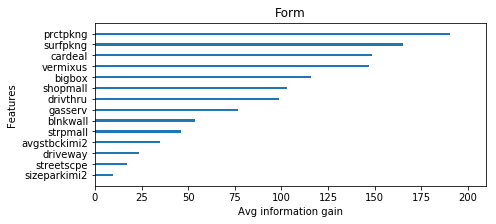

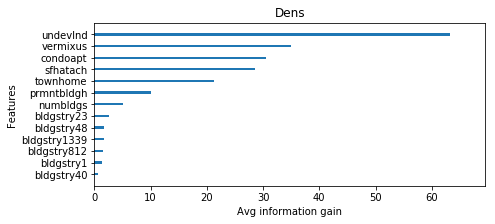

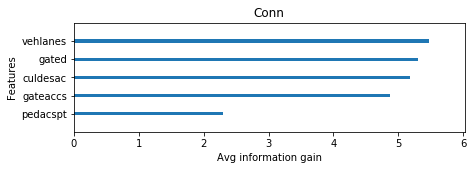

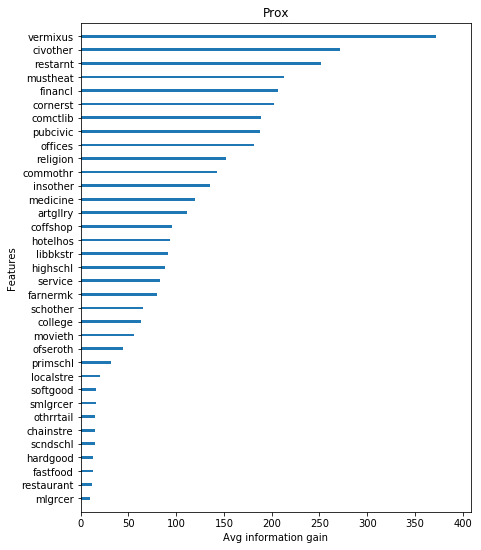

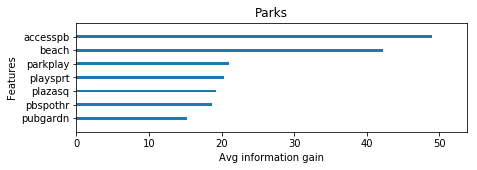

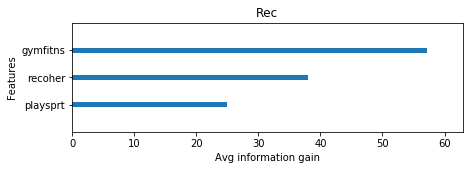

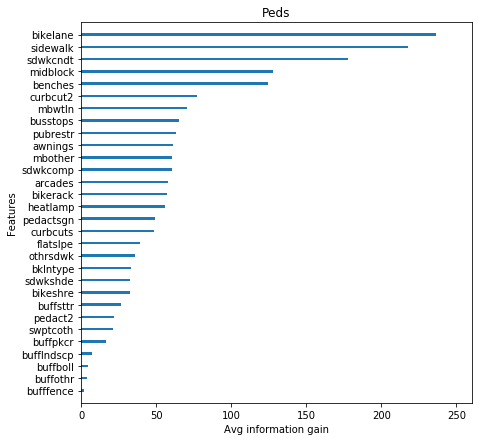

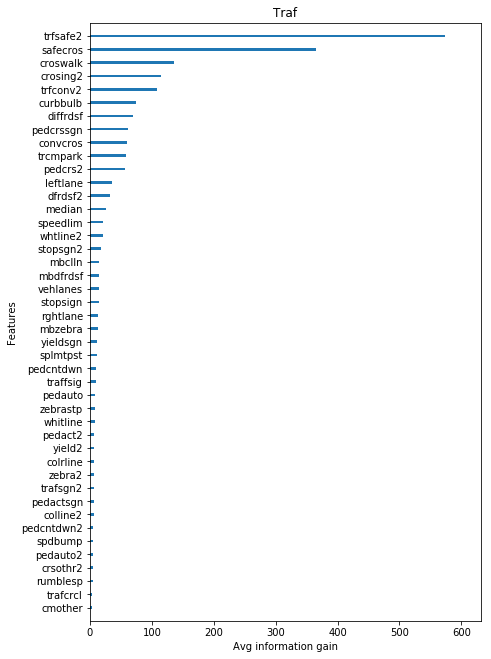

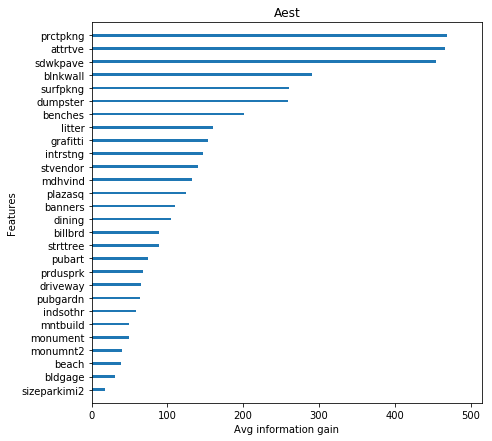

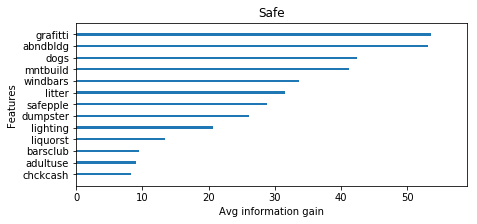

In [0]:
mode_type = 'XGB_all_vars'

for dim in dimensions.keys():

  model = joblib.load(path + '/XGBoost models/{}_{}.pkl'.format('XGB_all_vars', dim.upper()))

  n = len(model.feature_importances_)
  fig, ax = plt.subplots(figsize=(7,max(n//4,2)))

  xgb.plot_importance(model, ax=ax, title=dim, importance_type='gain', show_values=False, grid=False, xlabel='Avg information gain')

  plt.savefig(path + '/XGBoost models/{}_{}.png'.format('XGB_all_vars', dim.upper()), bbox_inches='tight')
  
  plt.show()

## Predict SoP dimensions for all NYC

In [0]:
dimensions = {
 'Form':'form3',
 'Dens':'dens2',
 'Conn':'conn5',
 'Prox':'prox3',
 'Parks':'parks2',
 'Rec':'paf2',
 'Peds':'peds3',
 'Traf':'traffic5',
 'Aest':'aesttot3',
 'Safe':'safe'
}

In [5]:
nyc_sop_vars = pd.read_csv(path + '/dataJoin/joined_road_segments/joined_final.csv')
nyc_sop_vars.head()

,id,coffshop,recoher,pedactsgn,townhome,spdbump,service,parkplay,mlgrcer,bldgstry40,softgood,bldgstry1,bikerack,bldgage,pedact2,strttree,gymfitns,playsprt,civother,sidewalk,surfpkng,buffsttr,othrrtail,pbspothr,pubgardn,pedcntdwn,kinder,bldgstry48,sizeparkimi2,hotelhos,vermixus,safepple,pedauto,bldgstry812,gasserv,highschl,pedcntdwn2,plazasq,chainstre,religion,...,mdhvind,comctlib,bikelane,farnermk,barsclub,pubcivic,beach,movieth,cardeal,liquorst,artgllry,shopmall,pedauto2,numbldgs,bldgstry23,othrsdwk,medicine,primschl,college,restaurant,driveway,mustheat,median,bikeretl,cornerst,vehlanes,prmntbldgh,culdesac,busstops,abndbldg,pedcrssgn,benches,libbkstr,linestring,intersection_1_longitude,intersection_1_latitude,intersection_2_longitude,intersection_2_latitude,intersection_1_id,intersection_2_id
0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,1,0,0,0,"[(-73.939496, 40.743525), (-73.9404517, 40.743...",-73.939496,40.743525,-73.940452,40.743627,42817478,42860546
1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,"[(-73.9417706, 40.7438315), (-73.9416387, 40.7...",-73.941771,40.743831,-73.940452,40.743627,42860543,42860546
2,3,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,0,"[(-73.941158, 40.74233), (-73.9407635, 40.7426...",-73.941158,40.742330,-73.940452,40.743627,42872051,42860546
3,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,"[(-73.940316, 40.744405), (-73.9404281, 40.743...",-73.940316,40.744405,-73.940452,40.743627,42872047,42860546
4,5,0,0,0,1,0,0,0,0,0,0,1,0,2,0,2,0,0,0,2,1,2,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,"[(-73.9335102, 40.6536262), (-73.933676, 40.65...",-73.933510,40.653626,-73.933676,40.655156,42510401,42467330


In [6]:
nyc_sop_vars.shape

(91666, 96)

In [7]:
%%time

mode_type = 'XGB_vml_vars'

for key, value in dimensions.items():

  model = joblib.load(path + '/XGBoost models/{}_{}.pkl'.format(mode_type, key.upper()))
  
  nyc_sop_vars[value.upper()] = model.predict(nyc_sop_vars.loc[:,model.get_booster().feature_names])

CPU times: user 445 ms, sys: 333 ms, total: 778 ms
Wall time: 3.67 s


In [8]:
nyc_sop_vars.loc[:10,[x.upper() for x in dimensions.values()]]

,FORM3,DENS2,CONN5,PROX3,PARKS2,PAF2,PEDS3,TRAFFIC5,AESTTOT3,SAFE
0,-7.809492,1.312970,-0.931710,-0.684070,-1.395603,-0.458275,8.864521,7.233681,5.201257,-10.332938
1,-7.809492,1.726369,-0.931710,-0.684070,-1.395603,-0.458275,21.181026,7.233681,8.736648,-3.628461
2,-7.809492,2.921196,-1.181347,0.860775,-1.395603,-0.458275,-0.449080,7.697672,8.530179,-10.332938
3,-7.809492,1.212505,-1.181347,0.860775,-1.395603,-0.458275,-0.449080,7.697672,5.498824,-3.628461
4,0.959903,3.857227,-0.931710,-0.626972,-1.395603,-0.458275,1.397577,7.233681,-0.154980,1.412148
5,-3.544449,3.154694,-0.931710,-4.690629,-1.395603,-0.458275,3.269123,7.233681,3.833468,1.412148
6,-3.544449,1.538793,-0.931710,-4.690629,-1.395603,-0.458275,3.269123,7.233681,3.833468,1.412148
7,-7.809492,6.324644,-0.931710,-0.684070,-1.395603,-0.458275,3.269123,7.233681,3.833468,1.412148
8,-3.544449,1.538793,-0.931710,-4.690629,-1.395603,-0.458275,1.397577,7.233681,3.833468,1.412148
9,-3.544449,2.528833,-1.181347,-4.690629,-1.395603,-0.458275,3.269123,7.697672,3.833468,-4.316454


In [9]:
nyc_sop_vars[[x.upper() for x in dimensions.values()]].describe()

,FORM3,DENS2,CONN5,PROX3,PARKS2,PAF2,PEDS3,TRAFFIC5,AESTTOT3,SAFE
count,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000,91666.000000
mean,-3.718483,2.185312,-0.379765,-0.722764,0.806683,-0.282800,2.690160,5.705663,3.749974,-2.665527
std,3.448564,2.745241,1.418523,6.818672,4.117578,1.073219,6.126114,4.146863,4.207206,4.065644
min,-7.809492,-3.722560,-1.181347,-5.710502,-1.395603,-0.458275,-14.074299,-11.430736,-9.566796,-39.470657
25%,-3.544449,0.760863,-1.181347,-4.690629,-1.395603,-0.458275,-0.146047,6.326670,0.516972,-3.628461
50%,-3.544449,2.528833,-0.931710,-4.690629,-1.395603,-0.458275,1.397577,7.233681,3.833468,-3.628461
75%,-3.544449,4.024195,-0.931710,0.860775,3.783961,-0.458275,3.269123,7.697672,4.151516,1.412148
max,21.921303,7.576381,10.210192,82.147644,33.937191,14.261218,36.141621,14.724581,31.648327,1.412148


## Calculate full SoP Index and normalize

In [0]:
add_dims = ['DENS2', 'PROX3', 'PARKS2', 'PAF2', 'PEDS3', 'TRAFFIC5', 'AESTTOT3', 'SAFE']
minus_dims = ['CONN5', 'FORM3']

In [0]:
nyc_sop_vars['SoPIndex6'] = nyc_sop_vars[add_dims].sum(axis=1) - nyc_sop_vars[minus_dims].sum(axis=1)

In [0]:
sop_min_max = {
  "FORM3":	{"min":-8.98156039502037, "max":43.1246636043055},
  "DENS2":	{"min":-8.04411518148277, "max":8.45366999059432},
  "PROX3":	{"min":-5.710502, "max":82.147644}, #Min and Max from NYC
  "CONN5":	{"min":-20.3310801789478, "max":15.6185137958015},
  "PARKS2":	{"min":-1.47949914351323, "max":56.8897925127854},
  "PEDS3":	{"min":-16.8177121324914, "max":78.977579097337},
  "SAFE":	{"min":-39.470657, "max":5.02173837842232}, #Min from NYC
  "TRAFFIC5":	{"min":-24.8506398262195, "max":25.6246999963054},
  "AESTTOT3":	{"min":-30.7534782194182, "max":68.5479715264353},
  "PAF2":	{"min":-0.459458427214951, "max":21.913865384033},
  "SoPIndex6":	{"min":-100.804225432961, "max":170.836300557805}
  }

In [0]:
for key, val in sop_min_max.items():
  nyc_sop_vars[key + '_norm'] = 100*(nyc_sop_vars[key] - val['min'])/(val['max'] - val['min'])

In [14]:
nyc_sop_vars.loc[:10,[x+ '_norm' for x in sop_min_max.keys()]]

,FORM3_norm,DENS2_norm,PROX3_norm,CONN5_norm,PARKS2_norm,PEDS3_norm,SAFE_norm,TRAFFIC5_norm,AESTTOT3_norm,PAF2_norm,SoPIndex6_norm
0,2.249382,56.717218,5.721076,53.962696,0.143733,26.809494,65.489211,63.564348,36.207664,0.005288,43.913539
1,2.249382,59.223003,5.721076,53.962696,0.143733,39.666604,80.558026,63.564348,39.767925,0.005288,52.369483
2,2.249382,66.465350,7.479416,53.268287,0.143733,17.087095,65.489211,64.483592,39.560004,0.005288,43.133840
3,2.249382,56.108261,7.479416,53.268287,0.143733,17.087095,80.558026,64.483592,36.507324,0.005288,43.857013
4,19.079225,72.139030,5.786065,53.962696,0.143733,19.014806,91.887175,63.564348,30.813748,0.005288,41.245994
5,10.434668,67.880682,1.160818,53.962696,0.143733,20.968499,91.887175,63.564348,34.830253,0.005288,43.306864
6,10.434668,58.086031,1.160818,53.962696,0.143733,20.968499,91.887175,63.564348,34.830253,0.005288,42.711996
7,2.249382,87.095080,5.721076,53.962696,0.143733,20.968499,91.887175,63.564348,34.830253,0.005288,47.518883
8,10.434668,58.086031,1.160818,53.962696,0.143733,19.014806,91.887175,63.564348,34.830253,0.005288,42.023017
9,10.434668,64.087076,1.160818,53.268287,0.143733,20.968499,79.011711,64.483592,34.830253,0.005288,41.230282


In [15]:
nyc_sop_vars[[x+ '_norm' for x in sop_min_max.keys()]].describe()

,FORM3_norm,DENS2_norm,PROX3_norm,CONN5_norm,PARKS2_norm,PEDS3_norm,SAFE_norm,TRAFFIC5_norm,AESTTOT3_norm,PAF2_norm,SoPIndex6_norm
count,91666.000000,91666.000000,9.166600e+04,91666.000000,91666.000000,91666.000000,9.166600e+04,91666.000000,91666.000000,91666.000000,91666.000000
mean,10.100264,62.003420,5.677050e+00,55.498266,3.916963,20.365311,8.272165e+01,60.542762,34.745884,0.790748,42.840767
std,6.620268,16.639891,7.760941e+00,3.947225,7.052029,6.395790,9.138936e+00,8.215609,4.237218,4.795995,7.005105
min,2.249382,26.194760,3.746523e-07,53.268287,0.143733,2.863829,-7.835784e-07,26.587051,21.335723,0.005288,17.371316
25%,10.434668,53.370666,1.160818e+00,53.268287,0.143733,17.403429,8.055803e+01,61.767410,31.490427,0.005288,38.935420
50%,10.434668,64.087076,1.160818e+00,53.962696,0.143733,19.014806,8.055803e+01,63.564348,34.830253,0.005288,42.540887
75%,10.434668,73.151091,7.479416e+00,53.962696,9.017515,20.968499,9.188717e+01,64.483592,35.150538,0.005288,46.618490
max,59.307432,94.682382,1.000000e+02,84.955819,60.676923,55.283858,9.188717e+01,78.405060,62.840780,65.795662,86.902381


In [0]:
nyc_sop_vars.to_csv(path + '/dataJoin/joined_road_segments/joined_final_predicted_sop.csv', index=False)